# TP Metric learning



In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

For this lab, we will use the [MNIST dataset (~15Mo)](https://en.wikipedia.org/wiki/MNIST_database). It consists of 28x28 images (loaded as a 784 vector) and the associated label for training, validation and test sets. 

The following code loads a subset of 1000 training samples and 500 validation samples.

5


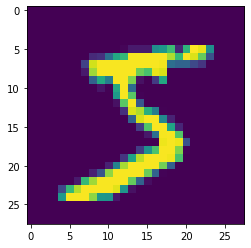

In [3]:
# Load the dataset
data = np.load('mnist1k.npz')
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_train_bin = data['X_train_bin']
y_train_bin = data['y_train_bin']
X_val_bin = data['X_val_bin']
y_val_bin = data['y_val_bin']
N_train = len(y_train)
N_val = len(y_val)
plt.imshow(X_train[0,:].reshape(28,28))
print(y_train[0])

## Implementing a $k$Nearest-Neighbor

#### Q1. Implement a class that encapsulate the squared euclidean distance ($\| x_1 - x_2 \|^2$) using the Distance parent class.


In [105]:
class Distance():
    '''
    trains this distance function on a training set
    '''
    def fit(self, X, y):
        pass
    
    '''
    returns the distance between the sets X1 and X2:
    X1 is n x d (n samples of dimension d)
    X2 is m x d (n samples of dimension d)
    output is n x m (distance matrix)
    '''
    def predict(self, X1, X2):
        pass

In [106]:
class L2Distance(Distance):
    def __init__(self):
        super().__init__()
    
    def predict(self, X1, X2):
        # your code

Q2. Implement a $k$NearestNeighbor class that relies on a Distance object to find the neighbors. It also trains the distance (by default, does nothing).

In [107]:
class KNN():
    def __init__(self, distance, k=1):
        self.distance = distance
        self.k = k
    
    '''
    trains the distance and memorizes the training set
    X: n x d (n samples of dimension d)
    y: n (n labels)
    '''
    def fit(self, X, y):
        # your code
    
    '''
    predict the set of samples
    '''
    def predict(self, X):
        #your code

We first try on the reduced training set to check that our code works. 

In [108]:
knn = KNN(L2Distance(), k=3)
knn.fit(X_train, y_train)
y_hat = knn.predict(X_train)
err = (y_hat != y_train).mean()
print('training error {}'.format(err))
y_hat = knn.predict(X_val)
err = (y_hat != y_val).mean()
print('val error {}'.format(err))

training error 0.10499999672174454
val error 0.3499999940395355


#### Q3. Implement a trainable $\ell_2$ distance function relying. I performs a linear projection $P$ such that the distance between similar samples is minimized, trained using gradient descent

$$ \min_P \sum_{x, x_p, y = y_p} \|Px - Px_p\|^2 $$

In [162]:
class L2MinDistance(Distance):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.P = np.random.randn(input_dim, output_dim)/jnp.sqrt(input_dim+output_dim)
        self.dist = L2Distance()
    
    @staticmethod
    def loss(P, X, y, dist):
        # your code
    
    @staticmethod
    def update(P, X, y, dist, eta=0.01):
        l, dp = jax.value_and_grad(L2MinDistance.loss, argnums=0)(P, X, y, dist)
        return l, P - eta*dp
        
    def fit(self, X, y):
        loss = []
        for i in range(1000):
            l, self.P = L2MinDistance.update(self.P, X, y, self.dist.predict)
            loss.append(l)
        plt.plot(loss)
        return
    
    def predict(self, X1, X2):
        # your code       
        

training error 0.07500000298023224
val error 0.5199999809265137


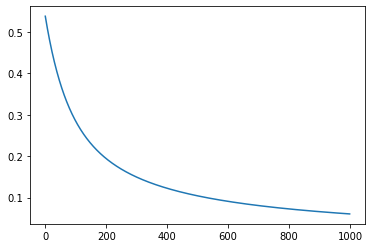

In [163]:
knn = KNN(L2MinDistance(784, 64), k=3)
knn.fit(X_train, y_train)
y_hat = knn.predict(X_train)
err = (y_hat != y_train).mean()
print('training error {}'.format(err))
y_hat = knn.predict(x_val)
err = (y_hat != y_val).mean()
print('val error {}'.format(err))

_Analyze your results in this box_

## Contrastive loss

Next, we want to mitigate the tendancy of only minimizing the distance to collapse all samples to the same location

#### Q3. Code a trainable distance function that minimizes the distance between related samples up to a margin and maximizes the distance between unrelated samples up to a margin

$$\min_p \sum_{x, x_p, y = y_p} \max(0, \|Px - Px_p\|^2 - \alpha) - \lambda \sum_{x, x_p, y \neq y_p} \max(0, \beta - \|Px - Px_p\|^2) $$

Plot the loss value as the gradient descent progresses

In [160]:
class L2ContrastiveDistance(Distance):
    def __init__(self, input_dim, output_dim, alpha=0.1, beta= 0.7, lambd=0.5):
        super().__init__()
        self.P = np.random.randn(input_dim, output_dim)/jnp.sqrt(input_dim+output_dim)
        self.dist = L2Distance()
        self.alpha = alpha
        self.beta = beta
        self.lambd = lambd
    
    @staticmethod
    def loss(P, X, y, alpha, beta, lambd, dist):
        # your code
    
    @staticmethod
    def update(P, X, y, alpha, beta, lambd, dist, eta=0.05):
        l, dp = jax.value_and_grad(L2ContrastiveDistance.loss, argnums=0)(P, X, y, alpha, beta, lambd, dist)
        return l, P - eta*dp
        
    def fit(self, X, y):
        loss = []
        for i in range(1000):
            l, self.P = L2ContrastiveDistance.update(self.P, X, y, self.alpha, self.beta, self.lambd, self.dist.predict)
            loss.append(l)
        plt.plot(loss)
        return
    
    def predict(self, X1, X2):
        # your code       
        

training error 0.004999999888241291
val error 0.4699999988079071


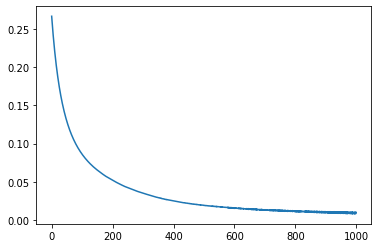

In [161]:
knn = KNN(L2ContrastiveDistance(784, 64), k=3)
knn.fit(X_train, y_train)
y_hat = knn.predict(X_train)
err = (y_hat != y_train).mean()
print('training error {}'.format(err))
y_hat = knn.predict(X_val)
err = (y_hat != y_val).mean()
print('val error {}'.format(err))

*Analyze your results on the full training set in this box*

## Triplet loss

Since $k$NN is in nature using a ranking approach by sorting the samples, we will know consider a loss function that enforces the order of the samples rather than their absolute distance values.

$$ \min_P \sum_{x, x_p, x_n, y = y_p, y \neq y_n} \max(0, \alpha + \|x - x_p\|^2 - \|x - x_n\|^2) $$

#### Q4. Code the triplet loss based trainable distance function.

In [169]:
class L2TripletDistance(Distance):
    def __init__(self, input_dim, output_dim, alpha=0.3):
        super().__init__()
        self.P = np.random.randn(input_dim, output_dim)/jnp.sqrt(input_dim+output_dim)
        self.dist = L2Distance()
        self.alpha = alpha
    
    @staticmethod
    def loss(P, X, y, alpha, dist):
        # your code
    
    @staticmethod
    def update(P, X, y, alpha, dist, eta=0.05):
        l, dp = jax.value_and_grad(L2TripletDistance.loss, argnums=0)(P, X, y, alpha, dist)
        return l, P - eta*dp
        
    def fit(self, X, y):
        loss = []
        for i in range(500):
            l, self.P = L2TripletDistance.update(self.P, X, y, self.alpha, self.dist.predict)
            loss.append(l)
        plt.plot(loss)
        return
    
    def predict(self, X1, X2):
        # your code   

training error 0.04500000178813934
val error 0.3700000047683716


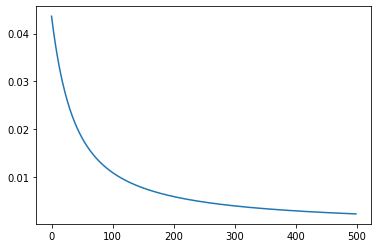

In [170]:
knn = KNN(L2TripletDistance(784, 64), k=3)
knn.fit(X_train, y_train)
y_hat = knn.predict(X_train)
err = (y_hat != y_train).mean()
print('training error {}'.format(err))
y_hat = knn.predict(X_val)
err = (y_hat != y_val).mean()
print('val error {}'.format(err))

*Analyze your results in this box*

#### Q5. Perform a cross validation on the margin, the number of dimensions and the number of neighbors.

*Analyze your results in this box*

## visualization

In order to visualize what is happening during the metric learning, we can interpret the projections of $P$ as images.

#### Q6. Extract the projection from a trained distance and plot each projector associated with each output space component as an image.

*Analyze your results in this box*